## Imports

In [10]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as pplt
from datetime import datetime, timedelta

In [11]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [12]:
def minusTime(startDate, t): 
    date = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = date- timedelta(days = t)
    return d.strftime('%Y-%m-%d')

def addTime(startDate, t): 
    date = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = date+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')

In [13]:
# here, start is a parameter that will indicate which of 3 sets of starting values to work with
def sampleMCMC(offset,data, pop, start, beta_start, gamma_start, rho_start):

    # splitting data into infections and time as numpy arrays
    dataDeath = data["cumDeath"].to_numpy()
    time = np.linspace(offset,offset+len(data)-1, len(data))

    # establishing model
    with pm.Model() as model:
        
        # create population number priors
        i0 = pm.Poisson('i0', mu=pop/10000)
        s0 = pm.Deterministic('s0', pop - i0)
        
        # creating priors for beta, gamma, and rho
        beta = pm.InverseGamma('beta', mu=.036, sigma=.5, testval=beta_start)
        gamma = pm.InverseGamma('gamma', mu=.047, sigma=.5, testval=gamma_start)
        rho = pm.TruncatedNormal('rho', mu=.034, sigma=.01, lower=0, upper=1, testval=rho_start)
        
        reproduciton = pm.Deterministic('R0', beta/gamma)

        # create number of removed based on analytic solution and above parameters
        sirRem = pm.Deterministic('sirRem',
            pop - ((s0 + i0)**(beta/(beta - gamma)))*
            (s0 + i0*tt.exp(time*(beta - gamma)))**(-gamma/(beta - gamma)))
        
        # create number of deaths as a fraction of number of removed
        sirDeath = pm.Deterministic('sirDeath', rho*sirRem)
        
        # create variance prior
        sigma = pm.HalfCauchy('sigma', beta=2)
        
        # create likelihood with modelled counts and observed counts
        obsDeath = pm.TruncatedNormal('obsDeath', mu=sirDeath, sigma=sigma,
                                     lower=0, upper=pop, observed=dataDeath)

        # specifying model conditions
        step=pm.NUTS(target_accept=.99)
        start=pm.find_MAP()
        
        # execute sampling
        model_trace = pm.sample(draws=1000, tune=1000, step=step, start=start, chains=5, cores=16)

    # return posterior samples and other information
    return model_trace

In [14]:
def runMCMC(df, population, start_date, end_date, offset, beta, gamma, rho):
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    mcmc = sampleMCMC(offset,df,population, 3, beta, gamma, rho)
    return mcmc    

In [15]:
def printMCMCTables(model):
    results = (pm.summary(model, var_names=['i0','beta','gamma','rho','sigma','R0'], round_to=5))
    return results

In [16]:
def plotMCMC(model):
    plot_trace = pm.plot_trace(model, var_names=('beta','gamma','rho','R0'), legend=True, chain_prop={"color":"rgbym"},figsize=(10.0,15.0))
    plot_pair = pm.plot_pair(model, var_names=('beta','gamma'), kind='kde')
    return plot_trace, plot_pair

## Preparing 

In [17]:
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-03-03','2020-03-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           }
}

# Preparing Beta, Gamma, Rho values
beta = [0.025, 0.030, 0.035, 0.36]
gamma = [0.038, 0.040, 0.044, 0.36]
rho = [0.025, 0.030, 0.035, 0.36]

## Running Analysis

In [18]:
country_names = ['France','Germany','Italy','Spain','UK']
quarantine_one_results = []
for country in country_names:
    df = dataset[country]['data']
    pop = dataset[country]['pop']
    date = dataset[country]['fLock'][0]
    result = []
    try:
        result.append(runMCMC(df,pop,date,addTime(date,20),10,beta[2],gamma[2],rho[2]))
        result.append(runMCMC(df,pop,date, addTime(date,40),10,beta[2],gamma[2],rho[2]))
    except:
        try:
            result.append(runMCMC(df,pop,date,addTime(date,20),10,beta[1],gamma[1],rho[1]))
            result.append(runMCMC(df,pop,date, addTime(date,40),10,beta[1],gamma[1],rho[1]))
        except:
            try:
                result.append(runMCMC(df,pop,date,addTime(date,20),10,beta[0],gamma[2],rho[0]))
                result.append(runMCMC(df,pop,date, addTime(date,40),10,beta[0],gamma[2],rho[0]))
            except:
                next
    quarantine_one_results.append(result)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

### Store parameter values

In [19]:
country_names = ['France','Germany','Italy','Spain','UK']
for index, results in enumerate(quarantine_one_results):
    # Before
    results_before = printMCMCTables(results[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    results_before = results_before.loc[["beta","gamma","rho",'i0','R0']]
    results_before.to_csv('mcmc_data/' + country_names[index] + '/fLock_before.csv')

    # After
    results_after = printMCMCTables(results[1])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    results_after = results_after.loc[["beta","gamma","rho",'i0','R0']]
    results_after.to_csv('mcmc_data/' + country_names[index] + '/fLock_after.csv')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


### Print Parameter Values (Full)

In [21]:
country_names = ['France','Germany','Italy','Spain','UK']
for index, results in enumerate(quarantine_one_results):
    # Before
    results_before = printMCMCTables(results[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    display(results_before)

    # After
    results_after = printMCMCTables(results[1])[['mean','sd','hdi_3%','hdi_97%','r_hat']]

Got error No model on context stack. trying to find log_likelihood in translation.


mean        sd      hdi_3%     hdi_97%    r_hat
i0     6739.84300  80.93765  6593.00000  6889.00000  1.00574
beta      0.22220   0.01678     0.19678     0.25373  1.00335
gamma     0.06820   0.01822     0.03869     0.10262  1.00321
rho       0.03968   0.00860     0.02339     0.05492  1.00334
sigma   305.54744  54.87376   215.81378   406.37596  1.00074
R0        3.41856   0.65505     2.29108     4.70593  1.00290

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


mean        sd      hdi_3%     hdi_97%    r_hat
i0     8303.23000  88.00697  8142.00000  8470.00000  1.00253
beta      0.17801   0.01487     0.15413     0.20503  1.00536
gamma     0.05818   0.01582     0.03231     0.08759  1.00335
rho       0.03953   0.00883     0.02276     0.05578  1.00495
sigma   185.81832  33.18517   130.57186   251.78527  1.00182
R0        3.20823   0.60440     2.06236     4.28328  1.00249

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


mean        sd      hdi_3%     hdi_97%    r_hat
i0     5911.27100  74.69460  5768.00000  6052.00000  1.00483
beta      0.33611   0.05495     0.25425     0.44112  1.00909
gamma     0.22649   0.05599     0.13589     0.32876  1.00889
rho       0.04269   0.00886     0.02648     0.05959  1.00928
sigma   334.69813  60.74432   239.62896   448.56690  1.00330
R0        1.51145   0.12097     1.29139     1.74105  1.00836

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     4747.15880   69.40196  4613.00000  4873.00000  1.00911
beta      0.30623    0.04374     0.23592     0.38549  1.00573
gamma     0.16905    0.04741     0.08903     0.25701  1.00550
rho       0.04253    0.00919     0.02687     0.06032  1.00396
sigma   574.92832  110.38429   392.02725   789.50477  1.00420
R0        1.88279    0.28731     1.41095     2.39448  1.00535

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6734.39480   81.35272  6582.00000  6885.00000  1.00465
beta      0.52818    0.10561     0.37194     0.73313  1.00703
gamma     0.42590    0.10682     0.26731     0.63338  1.00711
rho       0.04323    0.00906     0.02625     0.05993  1.00610
sigma   685.18042  121.77222   481.37764   905.65516  1.00465
R0        1.25433    0.06145     1.14721     1.37356  1.00690

Got error No model on context stack. trying to find log_likelihood in translation.


### Graph Results of Analysis

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got 

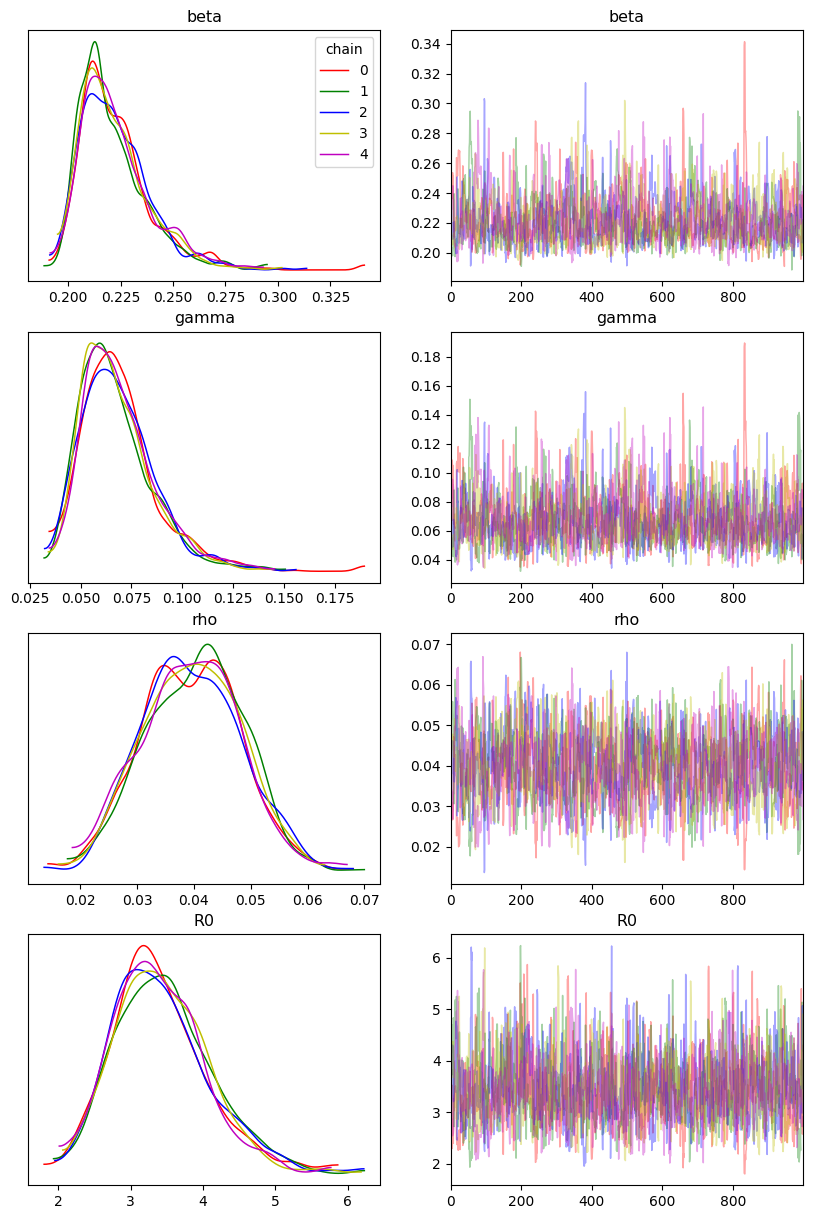

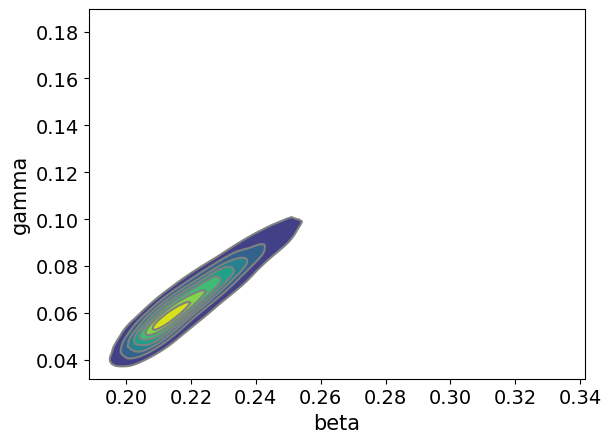

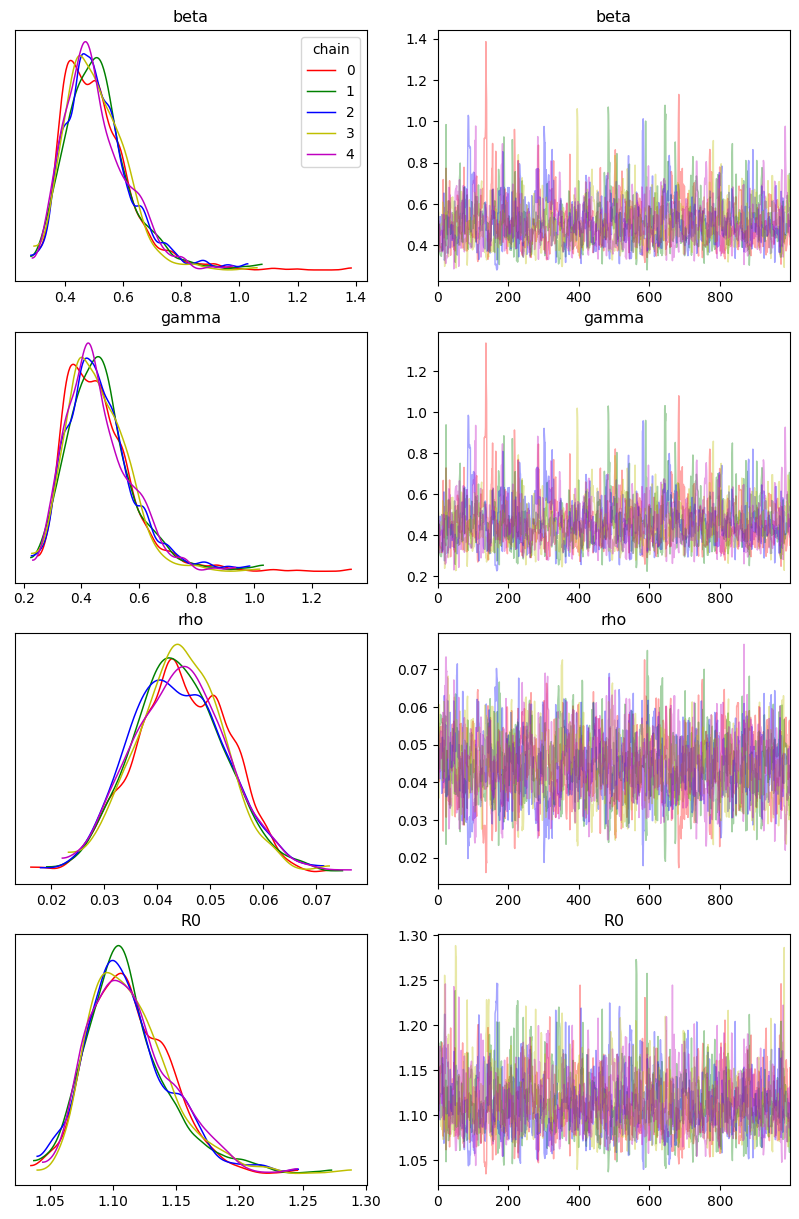

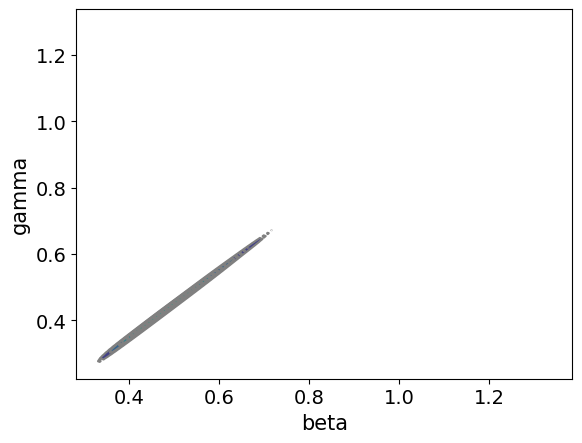

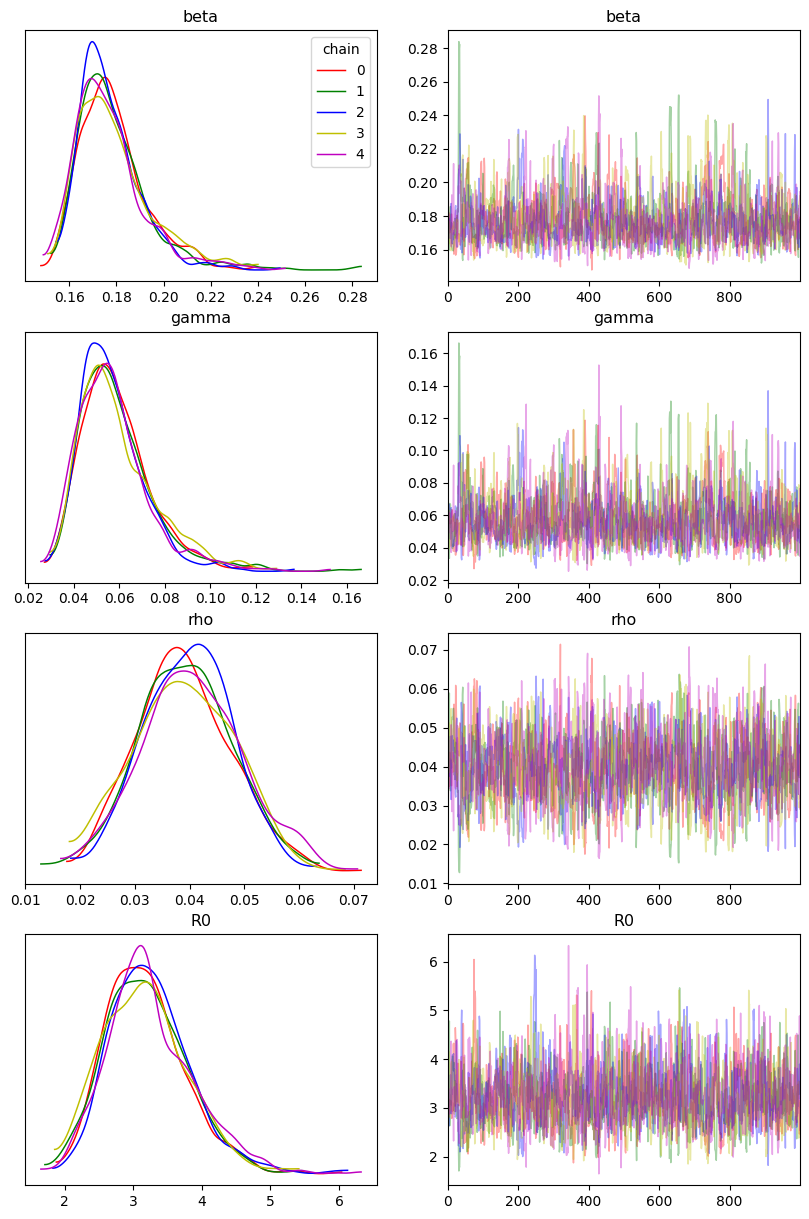

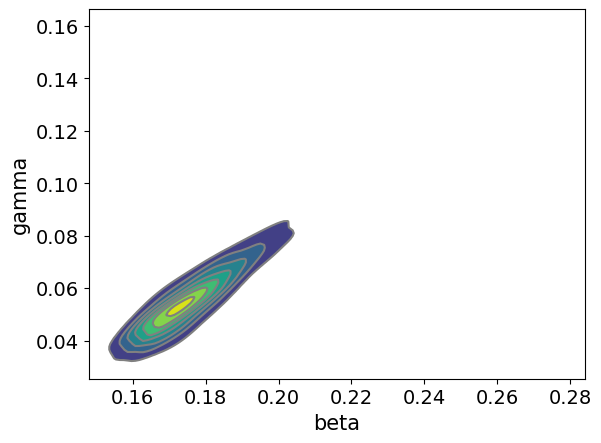

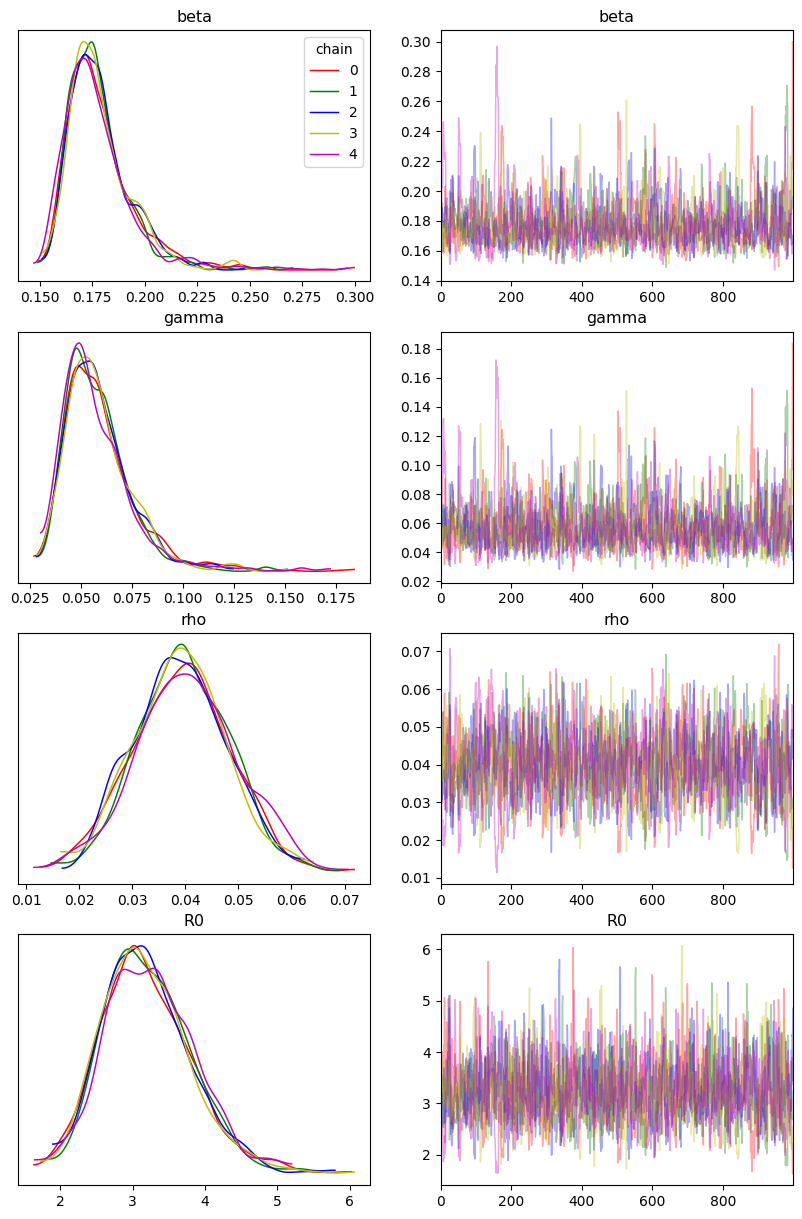

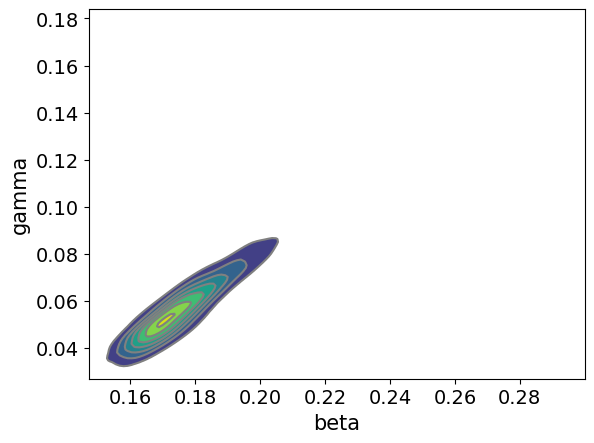

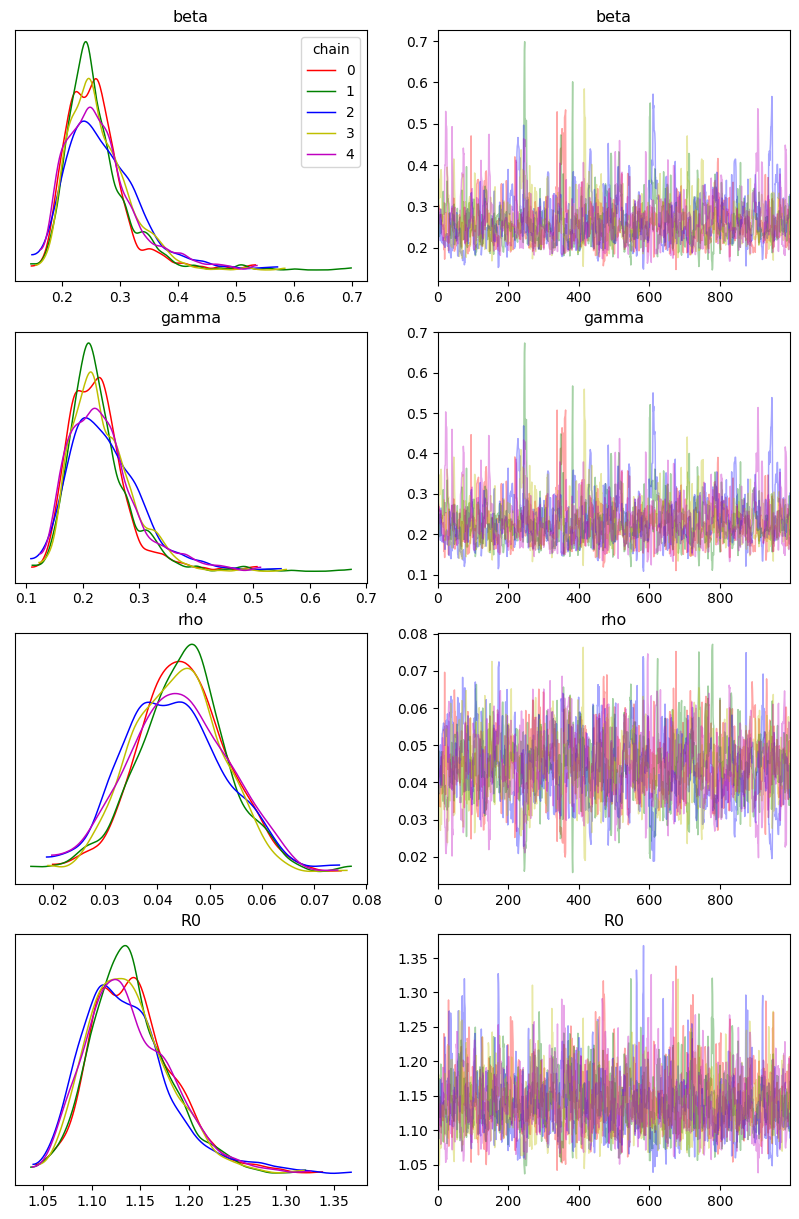

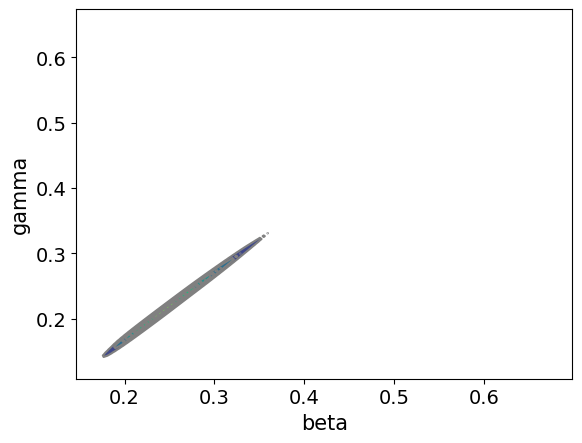

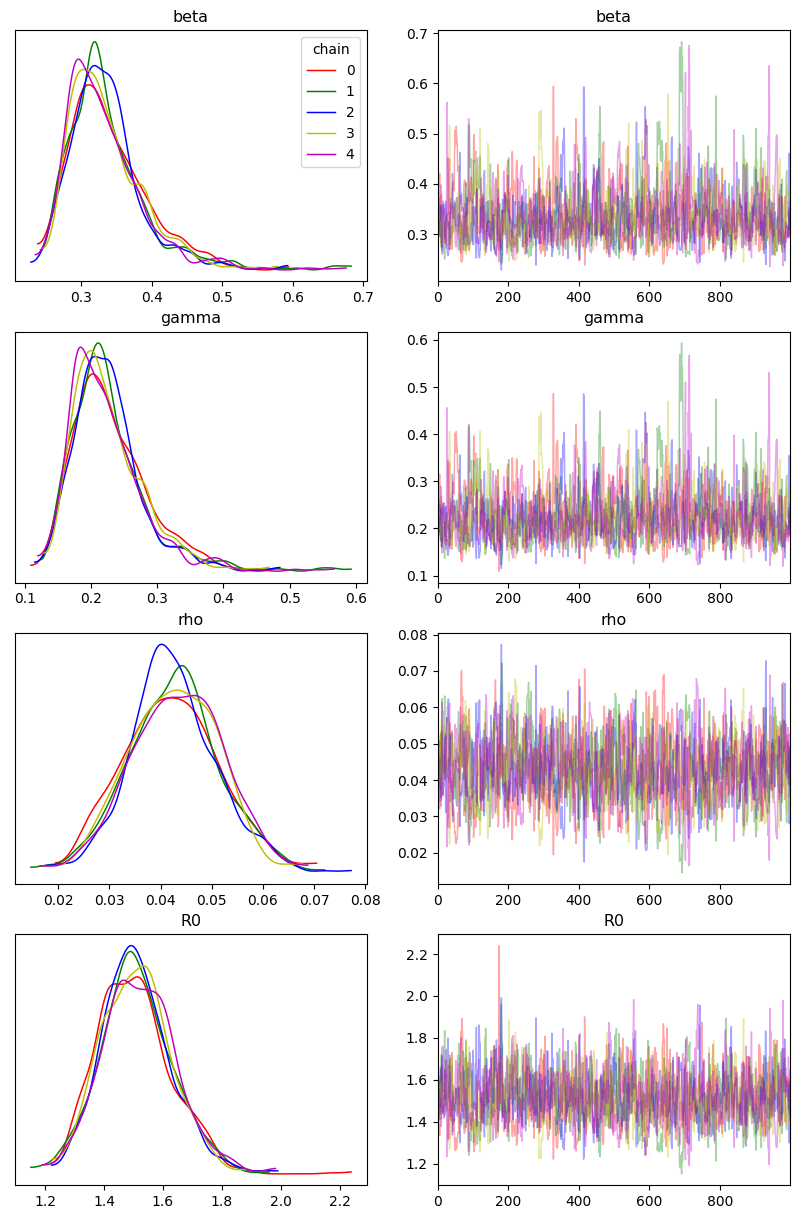

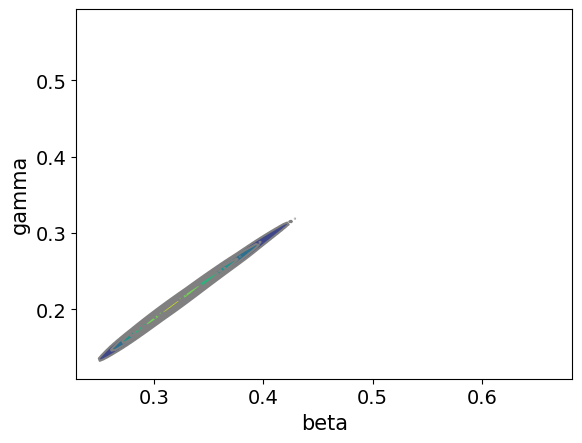

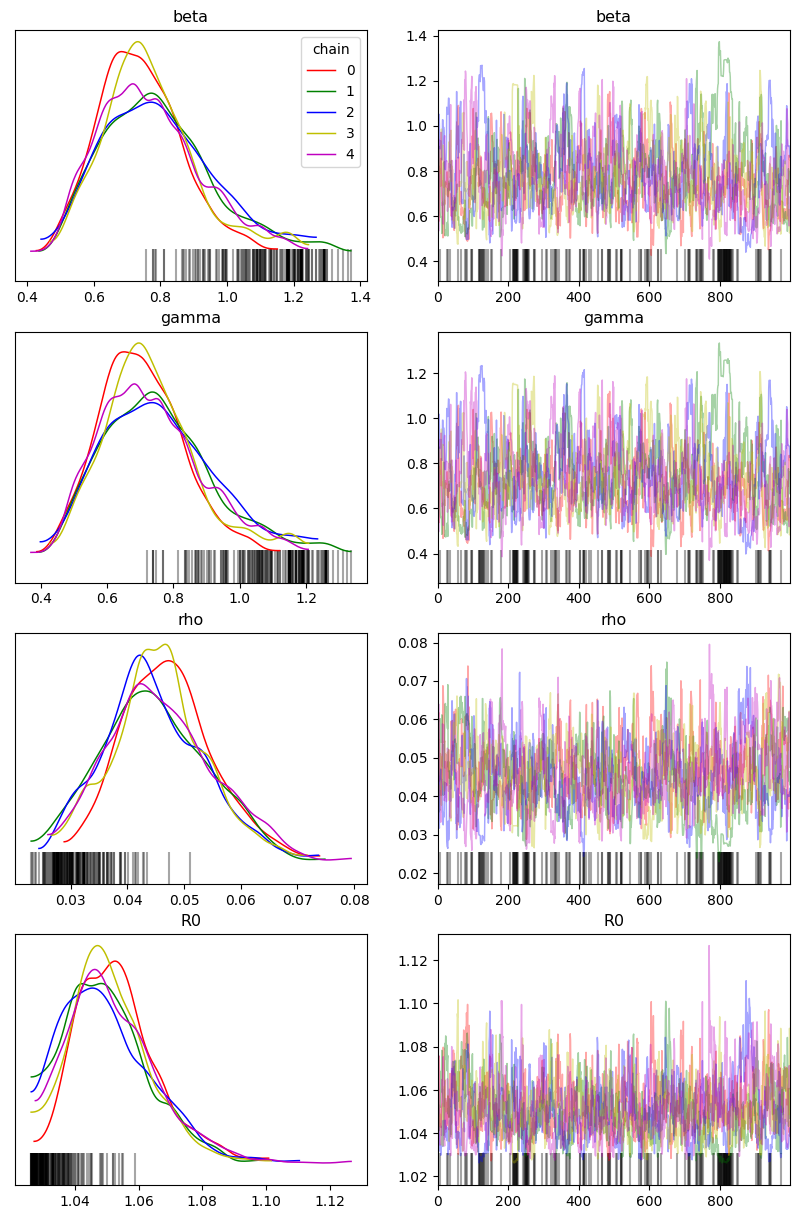

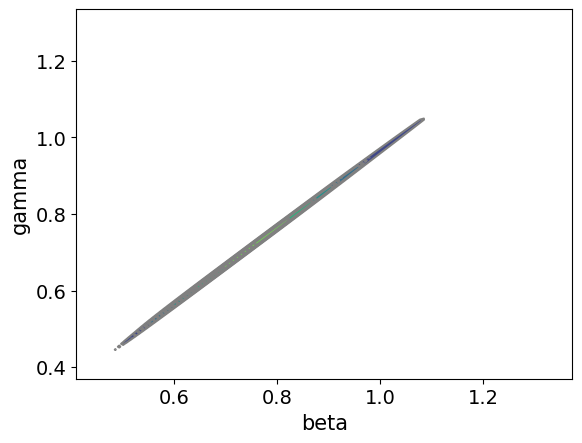

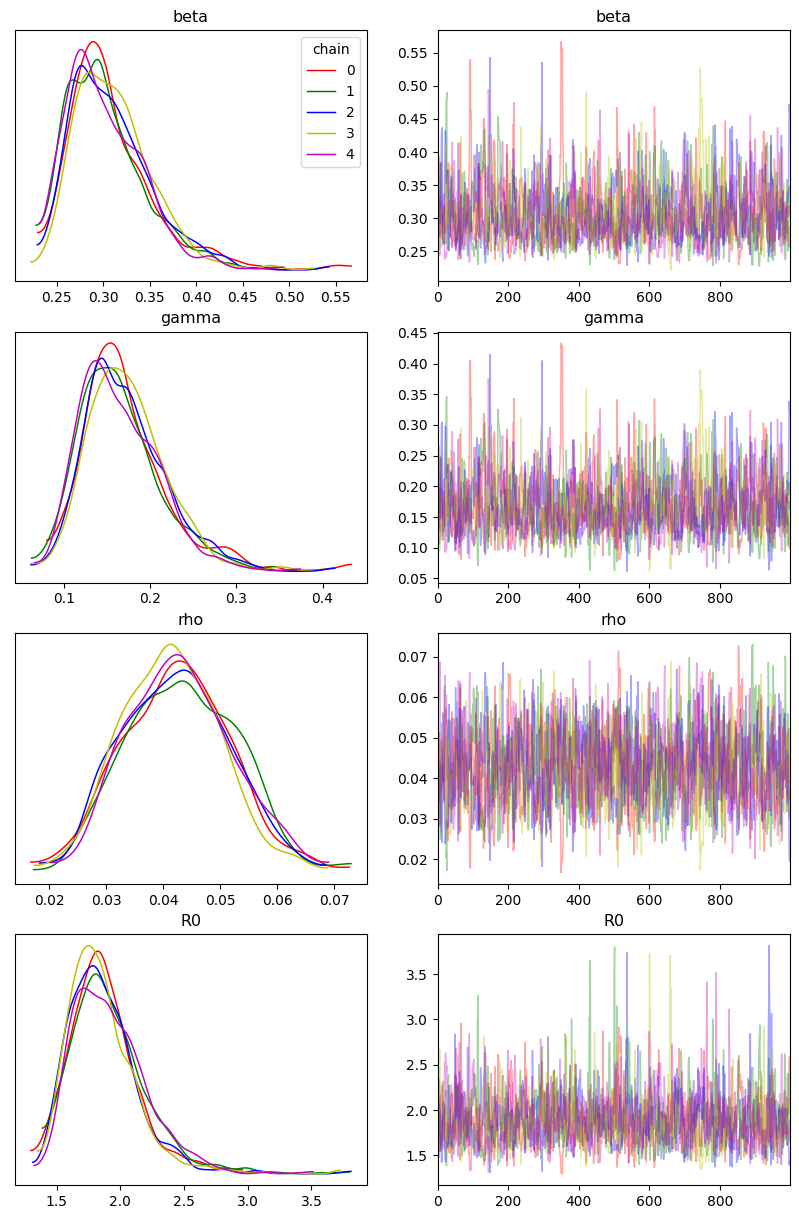

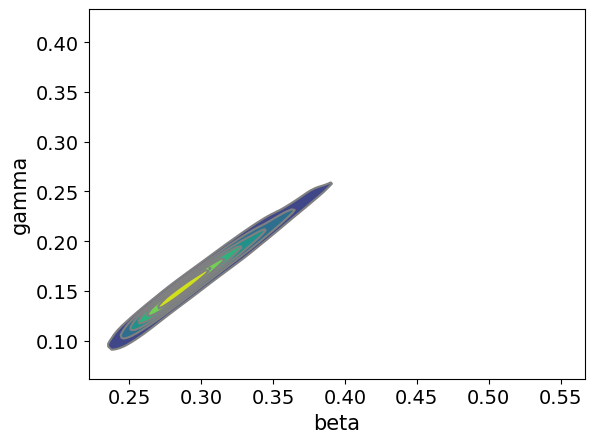

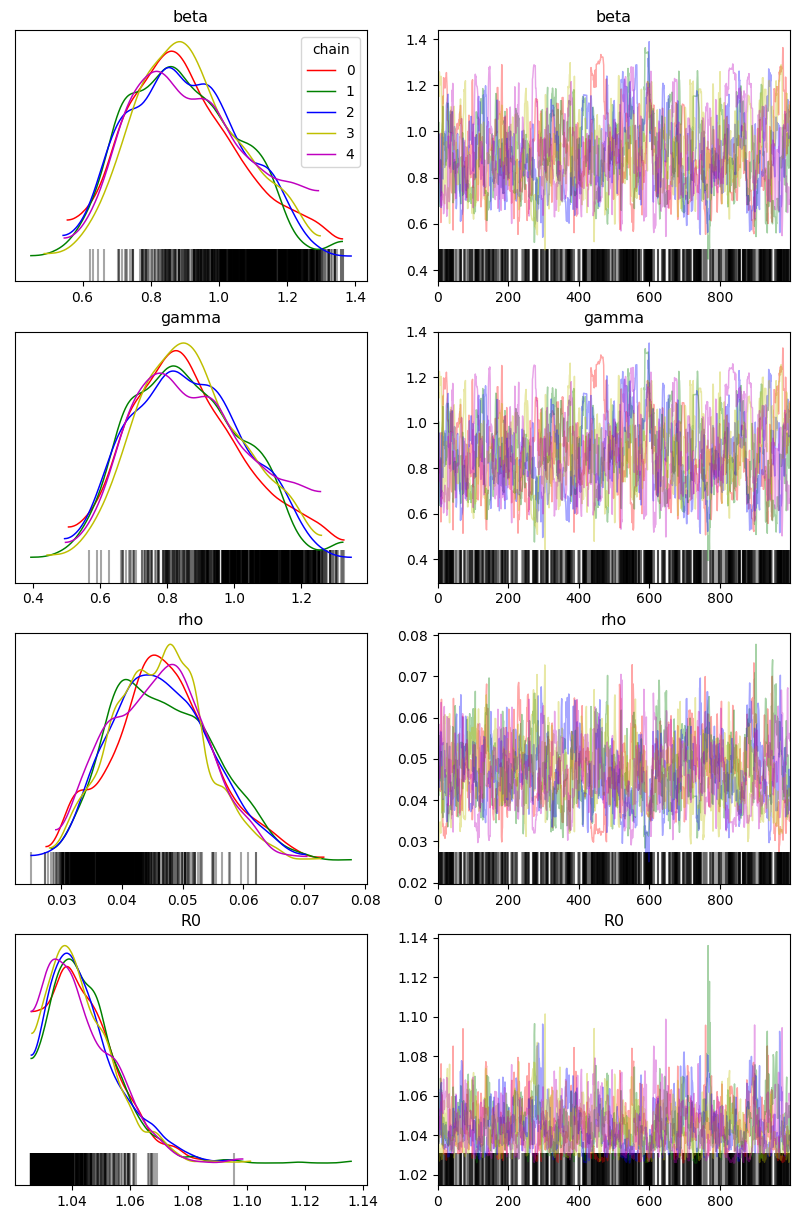

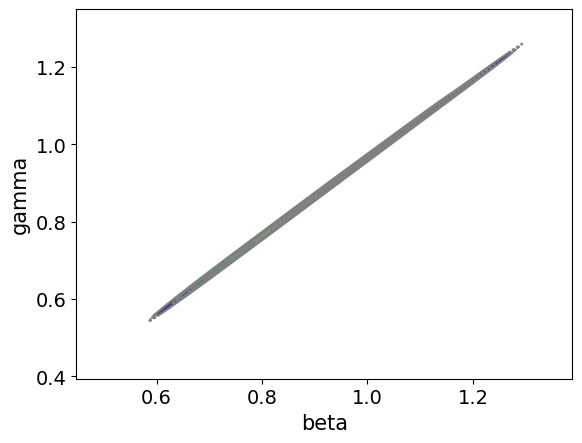

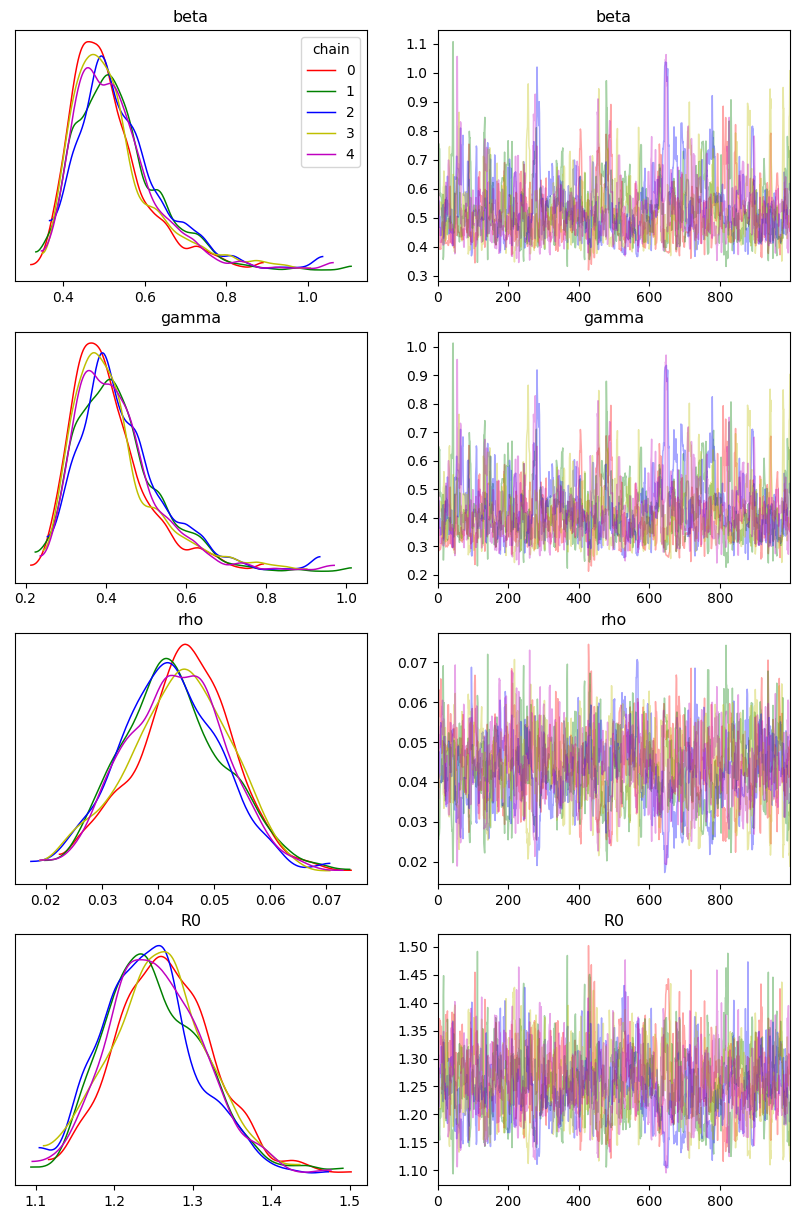

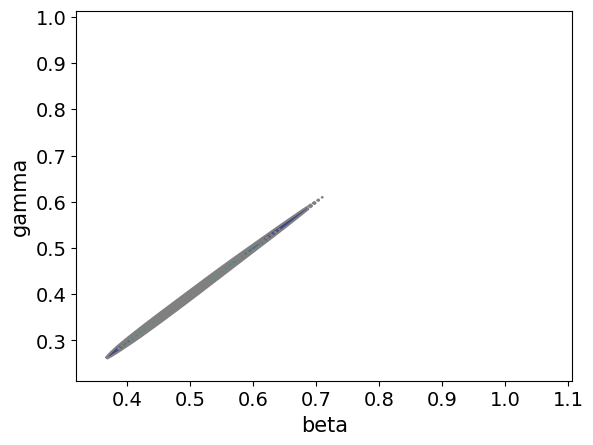

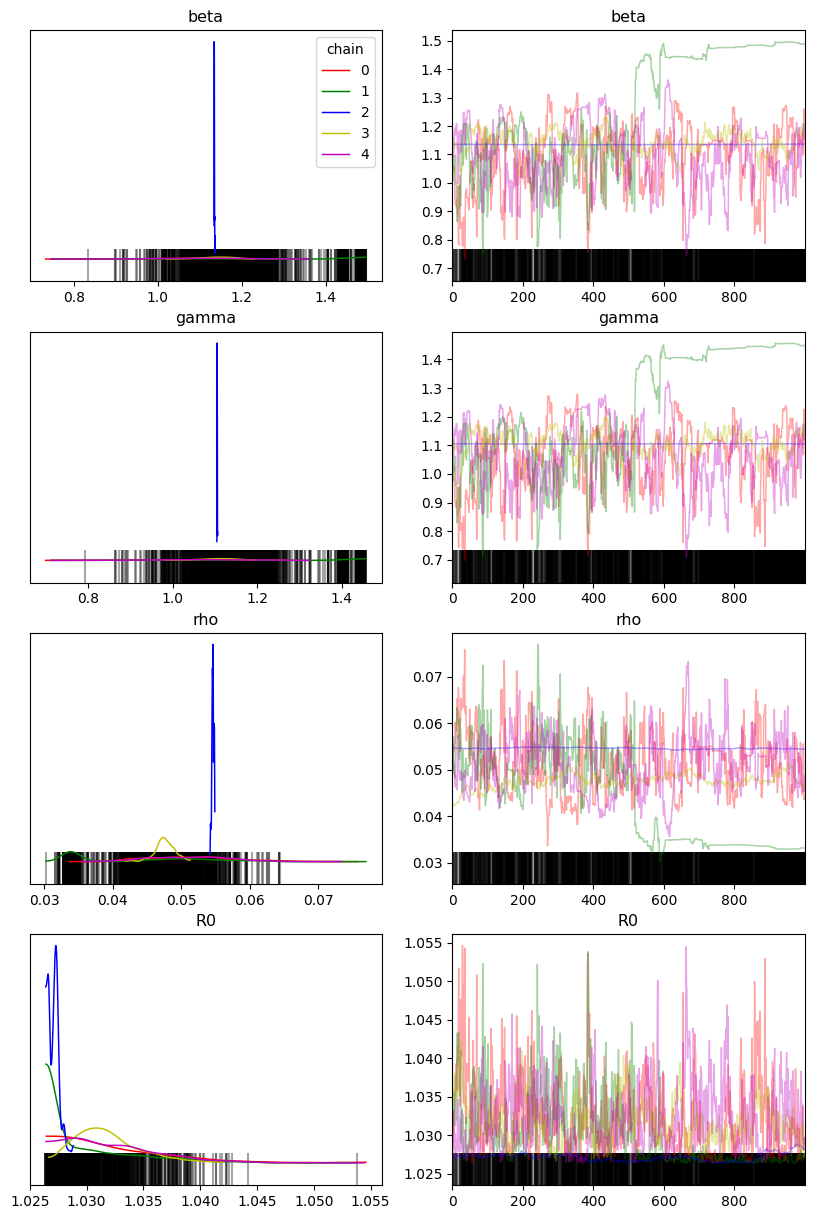

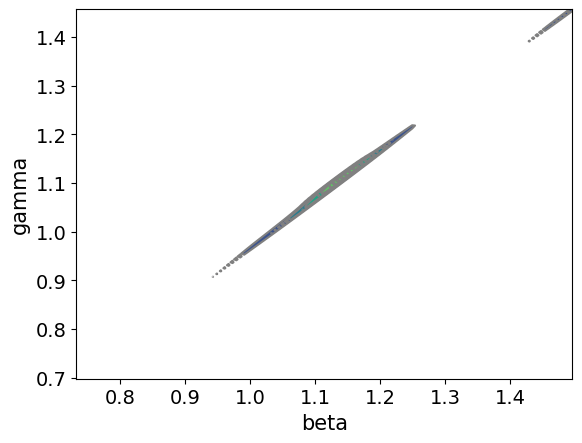

In [22]:
for index, country in enumerate(quarantine_one_results):
    for analysis in country:
        plotMCMC(analysis)